Empecemos un EDA de movies_dataset ya procesado 

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ver todas las columnas
pd.set_option('display.max_columns', None)

# Leemos todas nuestras tablas.
df = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\movies_dataset_etl.parquet')
genres_desanidado = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\genres_desanidado.parquet')
pc_desanidado = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\pc_desanidado.parquet')
pctry_desanidado = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\pctry_desanidado.parquet')
slan_desanidado = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\slan_desanidado.parquet')


### Empecemos con intuiciones, preguntas. Filtros que puedan ayudar a recomendar una pelicula o no.

Por ejemplo:
- Son todas peliculas de duracion normal? hay series? cortos?

Segun una busqueda simple del nombre y año de la peliculas que tienen outliers runtime(<30 | >1000). Resulta haber Miniseries, cortometrajes y peliculas.

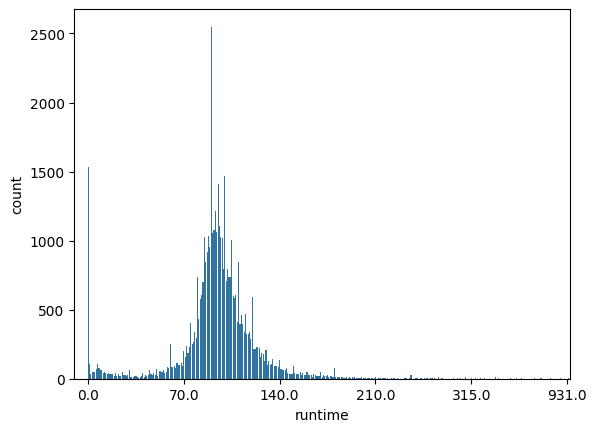

Mediana: 95.0
Media: 94.18167516064702
Moda: 90.0
desviacion std: 38.341058555455525


In [83]:
duracion = df['runtime'].dropna()
sns.countplot(x=duracion)
# Limitar el número de ejes X a 5 y correr el eje X para que 0 sea mas visible.
plt.xlim(left=-10)
plt.xticks(ticks=plt.gca().get_xticks()[::len(plt.gca().get_xticks()) // 5])
plt.show()

print('Mediana:',duracion.median())
print('Media:',duracion.mean())
print('Moda:',duracion.mode()[0])
print('desviacion std:',duracion.std())

Pero, tambien contiene nulos y muchos valores con 0 de duracion.

Vamos a rellenar los valores nulos y con 0.  Por su mediana(95) la cual no es afectada por outliers. Ya que la mediana es el centro de los valores ordenados.


In [87]:
mediana = int(df['runtime'].median())

# Reemplazar valores nulos (NaN) con la mediana
df['runtime'] = df['runtime'].fillna(mediana)
# Reemplazar valores de 0 con la mediana
df['runtime'] = df['runtime'].replace(0, mediana)

Ahora que no contiene nulos y su informacion esta mas distribuida. Vamos a categorizar estos datos por Corto (<50), Pelicula (entre 50 y 300), y miniserie (> 300). Ya que esto puede diferenciar  y aclarar el gusto de una persona mas que su numero 

de duracion.

Categorizado numericamente para el modelo. De esta forma:
- Corto : 0
- Pelicula corta : 1
- Pelicula muy larga: 2
- Miniserie : 3

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45376 entries, 0 to 45375
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   budget                   45376 non-null  float64       
 1   id                       45376 non-null  int64         
 2   original_language        45365 non-null  object        
 3   overview                 44435 non-null  object        
 4   popularity               45376 non-null  float64       
 5   release_date             45376 non-null  datetime64[ns]
 6   revenue                  45376 non-null  float64       
 7   runtime                  45376 non-null  float64       
 8   status                   45296 non-null  object        
 9   tagline                  20398 non-null  object        
 10  title                    45376 non-null  object        
 11  vote_average             45376 non-null  float64       
 12  vote_count               45376 n